<a href="https://colab.research.google.com/github/claudiosegala/Monografia/blob/master/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Dependencies

In this phase we have to download all the dependencies that our code will need

In [1]:
!pip install tensorflow
!pip install pandas
!pip install matplotlib
!pip install numpy
!pip install sklearn
!pip install keras

# Define headers

In this phase we have to declare all the libraries that we will use.

In [2]:
import tensorflow as tf # machine learning library
import pandas as pd # data manipulation library
import matplotlib.pyplot as plt # plot library
import numpy as np # math library
import datetime as dt # to discover week day
import time as tm # to convert to seconds
import sklearn as skl # regression templates library

from sklearn.metrics import mean_absolute_error, mean_squared_error, precision_score, accuracy_score, max_error

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

Using TensorFlow backend.


# Mount Drive

Connect to Google Drive of 'alfredcoinworth'

In [3]:
import google as g # To connect with google drive
g.colab.drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Configure Hyperparameters

In [0]:
n_steps = 20

n_features = 1

# Data Retrieval & Transformation

In this phase we have to get the data stored in Google Drive and remove the columns that we won't need. Also, convert some of them to other types.


In [0]:
def prepare_data (data):
  """ Prepare the data
  
  This will fix types of the dataframe to use time as seconds instead of string,
  use week day instead of date as string, use speed as float instead of string. 
  Also, will drop columns that are not necessary.
  """
  
  data = data.drop(columns=['Unnamed: 0', 'Sensor', 'Max Speed', 'Size', 'Lane'])
  
  data['Time'] = data['Time'].apply(lambda x : tm.strptime(x, '%H:%M:%S'))
  data['Time'] = data['Time'].apply(lambda x : dt.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds())
  data['Time'] = data['Time'].apply(lambda x : int(x))

  data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d')
  
  data['WeekDay'] = data['Date'].apply(lambda x : x.weekday())

  data['Speed'].apply(lambda x : float(x))
  
  return data



# Get data from Google Drive
data = pd.read_csv('/content/drive/My Drive/TCC/chunks/chunk_00.csv', sep=',')
data = prepare_data(data)


# Get Flow

This will transform the time series of register cars that passed in a array of flow per 5 minute.

In [0]:
def get_flow (data):
  """ Extract flow from data
  
  This will transform the time series of register cars that passed in a array of
  flow per 5 minute.
  """
  
  date = np.asarray(data['Date'])
  time = np.asarray(data['Time'])
  speed = np.asarray(data['Speed'])
  
  sz = len(speed)  
  dateControl = date[0] #seta o controle de data com o primeiro dia do chunk
  timeBlock = 300 #300 segundos, primeiro bloco de 5 minutos
  countFlow = 0
  flow_data = []

  for i in range(sz):
    if time[i] >= timeBlock: # init a new time block
      flow_data.append((date[i], timeBlock, countFlow)) 
      timeBlock += 300
      countFlow = 0 # TODO: verify if this is correct
      
    if date[i] > dateControl: # reset on day change
      dateControl = date[i]
      timeBlock = 300 
      countFlow = 0
      
    if time[i] < timeBlock: # add car on flow
      countFlow += 1

  #df_flow = pd.DataFrame(flow_data, columns = ["Day", "TimeBlock", "Flow"])
  
  return [f for d, t, f in flow_data ]


raw_seq = get_flow(data)

# Get Training and Test Data

In [0]:
def split_sequence(sequence, n_steps):
  """ Split a univariate sequence into samples
  
  This function will split a sequence into many samples in the form of two
  arrays. The first array will have as elements arrays of size n_step and the 
  second array will have as elements a integer. 
  Example:
  
  split_sequence([1, 2, 3, 4, 5], 3) #=> ([[1, 2, 3], [2, 3, 4]], [4, 5])
  """
  
  n = len(sequence)
  X, Y = list(), list()
  
  for i in range(n):
    # find the end of this pattern
    end_ix = i + n_steps

    # check if we are beyond the sequence
    if end_ix > n-1:
      break

    # gather input and output parts of the pattern
    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    Y.append(seq_y)

  return np.array(X), np.array(Y)


def reshape_flow (raw_seq, n_steps, n_features):  
  # define what is test and what is training
  training_side = int(len(raw_seq) * 0.8)
  
  # split into samples
  X_train, Y_train = split_sequence(raw_seq[:training_side], n_steps)
  X_test, Y_test = split_sequence(raw_seq[training_side:], n_steps)
  
  # reshape from [samples, timesteps] into [samples, timesteps, features]
  X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
  X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
  
  return X_train, Y_train, X_test, Y_test


X_train, Y_train, X_test, Y_test = reshape_flow(raw_seq, n_steps, n_features)

# Plot Data

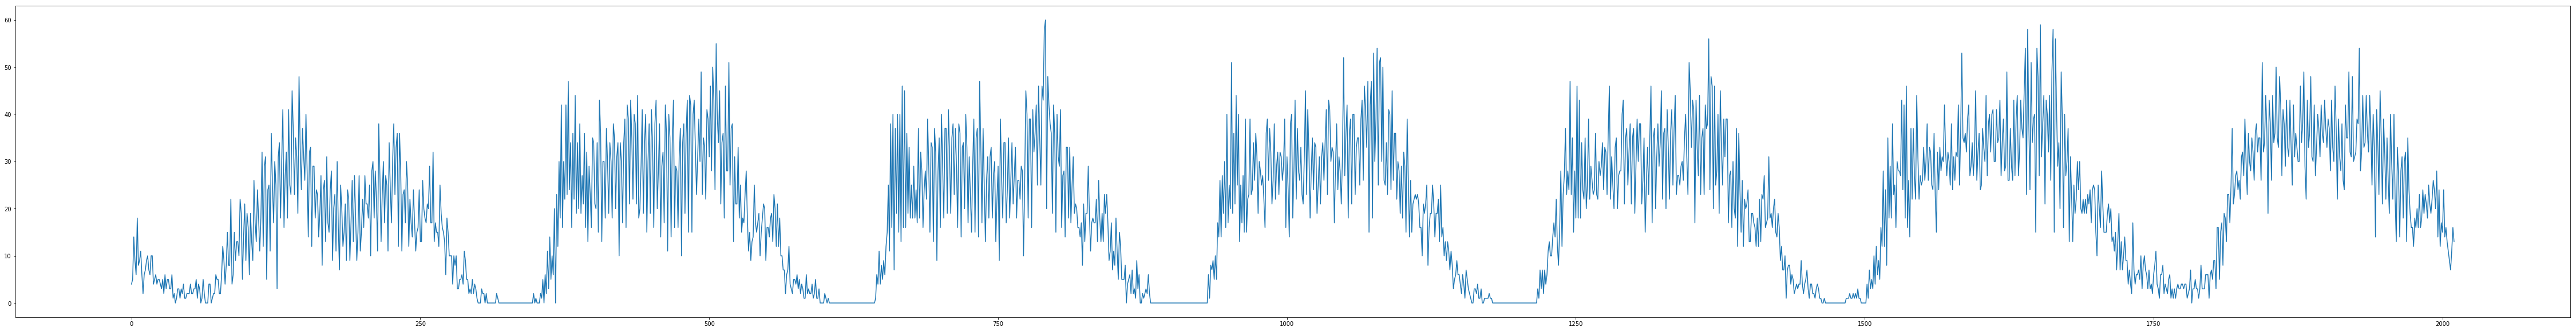

In [8]:
plt.figure(figsize=(80, 10))
plt.plot(raw_seq)

# Train LSTM

## TODO: scale?

In [9]:
def lstm (X_train, Y_train, X_test, Y_test, n_steps, n_features): 
  # define model
  model = Sequential()
  model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
  model.add(Dense(1))
  
  # compile model
  model.compile(optimizer='adam', loss='mse', metrics = ["accuracy"])
  
  # fit model
  model.fit(X_train, Y_train, batch_size=64, epochs=50, verbose=2)
  
  return model.predict(X_test, verbose=2)

Y_hat = lstm(X_train, Y_train, X_test, Y_test, n_steps, n_features)


W0825 17:00:10.041822 140579946665856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0825 17:00:10.096736 140579946665856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0825 17:00:10.106156 140579946665856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0825 17:00:10.552703 140579946665856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0825 17:00:10.795407 140579946665856 deprecation.py:323

Epoch 1/50
 - 2s - loss: 183.5620 - acc: 0.1612
Epoch 2/50
 - 0s - loss: 59.0633 - acc: 0.1713
Epoch 3/50
 - 0s - loss: 49.1278 - acc: 0.1644
Epoch 4/50
 - 0s - loss: 43.0267 - acc: 0.1461
Epoch 5/50
 - 0s - loss: 39.3859 - acc: 0.0907
Epoch 6/50
 - 0s - loss: 37.3199 - acc: 0.0919
Epoch 7/50
 - 0s - loss: 36.2815 - acc: 0.1744
Epoch 8/50
 - 0s - loss: 36.3661 - acc: 0.1178
Epoch 9/50
 - 0s - loss: 34.3533 - acc: 0.1751
Epoch 10/50
 - 0s - loss: 33.9571 - acc: 0.1555
Epoch 11/50
 - 0s - loss: 32.7980 - acc: 0.1757
Epoch 12/50
 - 0s - loss: 33.2576 - acc: 0.1681
Epoch 13/50
 - 0s - loss: 33.1885 - acc: 0.1707
Epoch 14/50
 - 0s - loss: 34.8553 - acc: 0.1738
Epoch 15/50
 - 0s - loss: 32.3600 - acc: 0.1436
Epoch 16/50
 - 0s - loss: 30.9628 - acc: 0.1770
Epoch 17/50
 - 0s - loss: 30.9205 - acc: 0.1832
Epoch 18/50
 - 0s - loss: 29.9987 - acc: 0.1738
Epoch 19/50
 - 0s - loss: 31.0022 - acc: 0.1889
Epoch 20/50
 - 0s - loss: 29.5729 - acc: 0.1707
Epoch 21/50
 - 0s - loss: 29.3893 - acc: 0.1858


# Test

In [11]:
def print_metrics (Y_hat, Y_test):
  mae = mean_absolute_error(Y_test, Y_hat)
  mse = mean_squared_error(Y_test, Y_hat)
  me = max_error(Y_test, Y_hat)
  
  print(f"MAE: {mae}")
  print(f"MSE: {mse}")
  print(f"RMSE: {np.sqrt(mse)}")
  print(f"Max Error: {me}")
  
print_metrics(Y_hat.round().flatten().tolist(), Y_test.tolist())

MAE: 5.099216710182768
MSE: 45.72584856396867
RMSE: 6.76208906802984
Max Error: 24.0
